In [4]:
#Run in Colab
useColab = True

#Init notebook and get data?
initNotebook = True

seed=6512
import numpy as np
np.random.seed(seed) # for reproducibility
import random
random.seed(seed)

import statistics
import pickle
import os

In [5]:
#Define hardware to use
#Set float 16,32 or 64 on supported GPUs
#https://www.kaggle.com/danmoller/keras-training-with-float16-test-kernel-2
DTYPE  = None       #defaults to float32
#DTYPE = 'float16'
#DTYPE = 'float32'
#DTYPE = 'float64'

#Use TPU
useTPU = False

In [6]:
#Init Local or Colab New
if initNotebook:
  if useColab:
    !pip3 install hdf5storage

    from google.colab import drive
    drive.mount('/content/gdrive')

    #import sys
    #sys.path.append('gdrive/My Drive/Colab Notebooks/classifier/lib')
    ##!cp gdrive/My\ Drive/Colab\ Notebooks/classifier/* .
    ##!python3 classifier-v10.py

if useColab:
  %run gdrive/My\ Drive/Colab\ Notebooks/lib/auxf.ipynb $useColab
  %run gdrive/My\ Drive/Colab\ Notebooks/lib/common.ipynb
else:
  %run lib/common.ipynb
  %run lib/auxf.ipynb $useColab
  
print("TF version: ",tf.__version__)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
aux 1.15.34
model 1.15.34
common 1.5.1
TF version:  2.2.0


In [7]:
#Install cuda 9.0
#BY Default is installed 10.0
#https://stackoverflow.com/questions/51888118/how-to-downgrade-tensorflow-version-in-colab
#
'''
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
'''
!nvcc --version
if useTPU == False:
  !nvidia-smi
os.system('uname -a')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Sat Jun 20 13:51:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+

0

In [8]:
#by Default on June, 27th 2019, TF==1.14.0rc1 GPU version
#IF installing tensorflow==1.14.0, JUST INSTALLs CPU SLOWER VERSION
#https://stackoverflow.com/questions/51888118/how-to-downgrade-tensorflow-version-in-colab
#
if useTPU:
  #Use pip3 install tensorflow-gpu==x.xx.x
  #!pip3 install tensorflow-gpu==1.12.0  #(1.67/15.6 secs) (NEEDS cuda 9.x)
  #!pip3 install tensorflow-gpu==1.13.1  #(1.67/15.6 secs) on T4 (0.1/full dataset) Faster on TPU!!!
  #!pip3 install tensorflow-gpu==1.14.0  #(2.71/17.7 secs)
  #!pip3 install tensorflow-gpu==1.14.0rc1  #(1.55/12.5 secs) (Default, on 27th june )
  #!pip3 install tensorflow-gpu==2.0.0b1 #(2.71/15.6 secs) #Fails detect TPU
  import tensorflow as tf
  print(tf.__version__)
  tfVersion114=False

In [9]:
import time
import os, sys

In [10]:
#If True use CNN else MLP (dense)
useCNN = '1D' # '2D' or None for dense MLP

In [11]:
#Signal config
#timeSegmentLength = 50000
#timeSegmentLength = 787   #for features file
#timeSegmentLength = 3072
#timeSegmentLength = 6144
timeSegmentLength = 6000
samplesSlice 	  = 1    #get smaller test set
samplesPart  	  = 0    #part to use (part > 0 works only with samplesSlice==2 for now)
windowSlice     = 1    #set smaller windows
numClasses      = 7    #Fault classes
oneHotEncode    = False

#reduce input by this factor getting only multiple elements of signal
#if underSample is 2 gets only the even elemnts of the 50000 points signal
#if underSample is 10 gets only the 1/10 elements, spaced by 10, of the 50000 points signal
#we can think of this as a step in a for
underSample = 1
inputLen : int = int(timeSegmentLength / underSample) 

In [12]:
# Model definition
if useCNN == '2D':
    conv2Drows   = 3       #no. of channels (update to 8)
    conv2Dcols   = 1       #If > 1 stack channel data slices

# '1D' or dense MLP
else:
    conv2Drows   = 1       #No 2nd dim in CNN
    conv2Dcols   = 1       #If > 1 stack channels, or stack channel data slices if only one channel
    
filters          = 32
dropOutRatio     = 0.5     #dropout ratio for dropout layer

In [13]:
#Train parameters
train = True
shuffleValData = False
epochs =  100
batchSize = 32

In [14]:
#Adaptive LR and early stop
decayLearningRate    = False
bouncingLearningRate = False
adaptLearningRate    = False
earlyStopStall       = False
metricES             = 'val_loss'
metricLR             = 'val_loss'  #metric to chg LR and earlyStop
earlyStopACC         = False
earlyStopACCmin      = 0.995 #0.995
initialLR            = 0.001  #None gives optimizer default: SGD dflt LR = 0.01, Adam = 0.001
minLR                = 1e-6
reduceLRFactor       = 0.5
esPatienceEpochs     = 5
alrPatienceEpochs    = 20
waitMonitorEpochs    = 0       #wait epoch before start monitoring measure
minDeltaStop         = 0.00001  #var to stop after esPatienceStop epochs
minDeltaLR           = 0.00001  #var to change LR after alrPatienceStop epochs

In [15]:
#optimizer setup
optimizer = tf.keras.optimizers.Adam(lr=initialLR)
#optimizer=tf.keras.optimizers.RMSprop(lr=initialLR) # loss='categorical_crossentropy', metrics=['acc', 'mae', 'mse'])
#optimizer=tf.keras.optimizers.Adagrad(lr=initialLR) # loss='categorical_crossentropy', metrics=['acc', 'mae', 'mse'])
#optimizer=tf.keras.optimizers.SGD(lr=initialLR)     # loss='mse', metrics=['acc', 'mae', 'mse'])
loss='mse'
metrics=['acc', 'mae', 'mse'] 
#loss=tf.keras.losses.sparse_categorical_crossentropy,
#metrics=['sparse_categorical_accuracy']
#loss=tf.keras.losses.categorical_crossentropy,
#metrics=['categorical_accuracy'])   

In [16]:
#I/O setup
loadModel   = False
saveModel   = True
forceCompileModel = True
saveEpochs = 1 #save at how many epochs

if useColab:
    recordpath='gdrive/My Drive/Colab Notebooks/00data/record/'
    exppath='gdrive/My Drive/Colab Notebooks/00data/record/experiments/'
    storagepath='gdrive/My Drive/Colab Notebooks/00data/storage/'
else:
    recordpath='/home/hdaniel/Downloads/record/'
    exppath='/home/hdaniel/Downloads/record/experiments/'
    storagepath='/home/hdaniel/Downloads/'

#loadModelFN     = recordpath + 'model-u1-e100-50000-10-estrides5.h5'
#loadModelFN     = recordpath + 'model-u1-e100-25000-10-estrides5.h5'
#loadModelFN     = recordpath + 'model-u1-e200-25000-10-estrides5-SGD0.001.h5'
#loadModelFN     = recordpath + 'modelBest-200+45.h5'
#loadModelFN     = recordpath + 'modelBest-2-100-100.h5'
#loadModelFN     = recordpath + 'modelBest-2-600.h5'
#loadModelFN     = recordpath + 'modelBest.h5'
#loadModelFN     = recordpath + 'cnnctbu/cnn32-3072-modelBest-1300.h5'
loadModelFN     = recordpath + 'cnnctbu/00-cnn32-no-500.h5'
loadModelFN     = recordpath + 'cnnctbu/00-cnn31-309e-LR0.0005-2000pts-acc100loss0.h5'
saveBestModelFN = recordpath + 'modelBest.h5'
#saveBestModelFN = recordpath + 'bouncing/{epoch:04d}-{l5:08d}-{val_loss:.5f}-{val_acc:.5f}-' + 'modelBest.h5'
saveLastModelFN = recordpath + 'modelLast.h5'
#dataFN          = storagepath + 'raw_50000_003_dataset_Quantile_4_classes.mat'  #4 classes
#dataFN          = storagepath + 'raw_50000_003_qnorm_even.mat'  #36 classes
#dataFN          = storagepath + 'datactbu.mat' #unshuffled
#dataFN          = storagepath + 'datactbuset.mat'#shuffled
#dataFN          = storagepath + 'dataualg.mat'
#dataFN          = storagepath + 'raw_3channels-new.mat'
#dataFN          = storagepath + 'raw_3channels-s1000.mat'
dataFN          = storagepath + 'raw_3channels-w2000-r01.mat'
#dataFN          = storagepath + 'features_TS_50000_Ch_003_TR_90_TST_10_dataset_Quantile_4_classes.mat'

logFN           = exppath + 'experiment.log'

# Main

In [17]:
#%run aux.ipynb $useColab
#%run gdrive/My\ Drive/Colab\ Notebooks/classifier/aux.ipynb $useColab

In [18]:
import numpy as np, scipy.io
print(dataFN)
scipy.io.whosmat(dataFN)

gdrive/My Drive/Colab Notebooks/00data/storage/raw_3channels-w2000-r01.mat


[('X', (7000, 6000), 'single'), ('Y', (7000, 7), 'uint8')]

In [19]:
def initData(data):
    print('Preparing data ...') 
    #For quantile dataset or shuffled sets 
    #trainXs, trainYs, testXs, testYs = getData1(data, underSample)
    #For raw dataset (36 classes)
    #needs too much memory better do it offline
    #trainXs, trainYs, testXs, testYs = getData2(data, 36, 0.9, underSample, 'features', 'labels')
    #For CTBU unshuffled dataset
    trainXs, trainYs, testXs, testYs = getData2(data, numClasses, 0.8, underSample)
    print('done')

    #From 36 to 4 classes
    if numClasses == 4:
        to4classesSet = [(0, 0), (1, 7), (8, 14), (15, 35)]
        trainYs = joinClasses(trainYs, to4classesSet)
        testYs  = joinClasses(testYs,  to4classesSet)

    print('Setting up data ...')
    trainXs, trainYs, testXs, testYs = setupData(
          trainXs, trainYs, testXs, testYs, 
          numClasses, samplesSlice, samplesPart, windowSlice, 
          conv2Drows, conv2Dcols, underSample, useCNN, DTYPE)
    print('done')  

    if oneHotEncode:
        #Transform in one:hot encoding
        #Must use in the optimizer tf.keras.losses.categorical_crossentropy
        #rather than: tf.keras.losses.sparse_categorical_crossentropy
        #If using sparse one_hot is handled by the optimizer must supply not one_hot encoded
        trainYs = one_hot(trainYs, numClasses) 
        testYs  = one_hot(testYs,  numClasses) 
  
    return trainXs, trainYs, testXs, testYs
  
#Setup data
if initNotebook:
    print('Loading data ...')
    data = loadData(dataFN)
    print('done.')        
trainXs, trainYs, testXs, testYs = initData(data)

Loading data ...
done.
Preparing data ...
0
1
2
3
4
5
6
done
Setting up data ...
done


In [20]:
#Print number of samples by classes
#Unique classes
print(np.unique(trainYs, return_counts=True, axis=0)[0])
print(np.unique(testYs, return_counts=True, axis=0)[0])
#Number of samples of each unique class
print(np.unique(trainYs, return_counts=True, axis=0)[1])
print(np.unique(testYs, return_counts=True, axis=0)[1])

[[0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[800 800 800 800 800 800 800]
[200 200 200 200 200 200 200]


(5600, 6000, 1) (5600, 7) (1400, 6000, 1) (1400, 7)
[[-1.6363914 ]
 [ 0.50326234]
 [ 1.114592  ]]
[0 1 0 0 0 0 0]


'\nwith seed(1024), trainXs[101, 7:10]:\n[[-16.613968]\n [-15.085644]\n [-15.085644]]\n [0 0 0 0 0 1 0]\n'

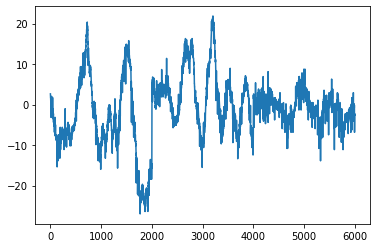

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

print(trainXs.shape, trainYs.shape, testXs.shape, testYs.shape)
print(trainXs[101, 7:10])
print(trainYs[101,:])

if useCNN == '1D':
    plt.plot(trainXs[5010,:])
if useCNN == '2D':
    plt.plot(trainXs[5010,:].flatten().reshape(trainXs.shape[1], conv2Dcols*conv2Drows))
'''
with seed(1024), trainXs[101, 7:10]:
[[-16.613968]
 [-15.085644]
 [-15.085644]]
 [0 0 0 0 0 1 0]
'''

In [22]:
def prepareInput(X, y, batchSize=256, shuffle=False):
    seed = 0
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(X.shape[0], seed, reshuffle_each_iteration=True)
    dataset = dataset.repeat() #repeat same dataset next epoch
    dataset = dataset.batch(batchSize, drop_remainder=True) #drops remaining samples < batchSize
    # Return the dataset.
    return dataset

def setUpModel(inputLen):  
    #Load or setup model
    if loadModel:
        print('Loading ANN model ...')
        model = tf.keras.models.load_model(loadModelFN)
        #force change optimizer and metrics
        if forceCompileModel:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    else:
        print("Setting up ANN model ...")
        if useCNN == '1D':
            model = setupModel(inputLen, numClasses, windowSlice, conv2Dcols, dropOutRatio, filters)
        if useCNN == '2D':
            model = setupCNN2D(inputLen, numClasses, windowSlice, conv2Drows, conv2Dcols, dropOutRatio, filters)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    #can also save and load TPU model
    if useTPU:
        print('Setting up TPU ANN model ...')
        if tfVersion114:
            model = setupTPUModel114(inputLen, numClasses, windowSlice, conv2Dcols, dropOutRatio, filters)
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        else:
          model = setupTPUModel(model)

        """
        try:
            deviceName = os.environ['COLAB_TPU_ADDR']
            TPUaddr = 'grpc://' + deviceName
            print('Found TPU at: {}'.format(TPUaddr))
        except KeyError:
            print('TPU not found')
            sys.exit(0)

        if tfVersion114:
            resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPUaddr)
            tf.config.experimental_connect_to_host(resolver.master())
            tf.tpu.experimental.initialize_tpu_system(resolver)
            strategy = tf.distribute.experimental.TPUStrategy(resolver)
            with strategy.scope():
                model = setupModel(inputLen, numClasses, windowSlice, conv2Dcols, dropOutRatio, filters)
        else:
            model = tf.contrib.tpu.keras_to_tpu_model(
                model,
                strategy=tf.contrib.tpu.TPUDistributionStrategy(
                tf.contrib.cluster_resolver.TPUClusterResolver(
                tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
                ))
        """    

    return model

  
def setupCallbacks():
    #Callbacks setup
    callbacks = []
    if saveModel:
        ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
            #default: monitor='val_acc',
            filepath=saveBestModelFN, verbose=1, period=saveEpochs, save_best_only=True)
        callbacks.append(ModelCheckpoint)
    #EarlyStopStall
    if earlyStopStall:
        eStopStall = tf.keras.callbacks.EarlyStopping(
            monitor=metricES, min_delta=minDeltaStop, patience=esPatienceEpochs, verbose=1)
        callbacks.append(eStopStall)    
    #EarlyStopACC
    if earlyStopACC:
        '''DOES NOT WORK'''
        '''
        eStopACC = tf.keras.callbacks.EarlyStopping(
            monitor='val_acc', baseline=earlyStopACCmin, patience=0)
        callbacks.append(eStopACC)
        '''
        class TerminateOnACC(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={None}):
                valacc = logs.get('val_acc')
                if valacc >= earlyStopACCmin:
                    print('\nEpoch {}: Reached baseline val_acc {} ({})'.format(epoch+1, earlyStopACCmin, valacc))
                    self.model.stop_training = True
        tacc = TerminateOnACC()
        callbacks.append(tacc)
    #learning factor reduce   
    if adaptLearningRate:
        reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
            monitor=metricLR, factor=reduceLRFactor, min_lr=minLR,  min_delta=minDeltaLR, cooldown=waitMonitorEpochs, patience=alrPatienceEpochs)
        callbacks.append(reduceLR)
        #print learning rate callback
        class LearningRateMonitor(tf.keras.callbacks.Callback):
            def on_epoch_begin(self, epoch, logs=None):
                print("learning rate: ", tf.keras.backend.eval(self.model.optimizer.lr))
        lrm = LearningRateMonitor()
        callbacks.append(lrm)
    #Increase and decrease learning rate                                    
    if bouncingLearningRate:
        class bounceLearningRate(tf.keras.callbacks.Callback):
            def __init__(self, epochs=40, dFact=0.5, up=0.0005, dn=0.00025):
                self.lrpat   = epochs
                self.lrdecayFactor = dFact
                self.lrdecay = self.lrdecayFactor
                self.upLimit = up
                self.dnLimit = dn
            def on_epoch_begin(self, epoch, logs=None):
              if epoch >= self.lrpat:
                if epoch % self.lrpat == 0:
                    lr = tf.keras.backend.eval(self.model.optimizer.lr)
                    if lr >=  self.upLimit: self.lrdecay = self.lrdecayFactor
                    if lr <=  self.dnLimit: self.lrdecay = 1 / self.lrdecayFactor
                    tf.keras.backend.set_value(model.optimizer.lr, lr*self.lrdecay)
                    print("Epoch: ", epoch+1, " learning rate: ", tf.keras.backend.eval(self.model.optimizer.lr))
        blr = bounceLearningRate()
        callbacks.append(blr)
    #decaying learning rate                                    
    if decayLearningRate:
        class decayingLearningRate(tf.keras.callbacks.Callback):
            lrates = [0.001, 0.0001, 0.00001, 0.000001]
            lridx  = 0
            lrpat  = 50 #epochs
            def on_epoch_begin(self, epoch, logs=None):
                if epoch % self.lrpat == 0:
                    tf.keras.backend.set_value(model.optimizer.lr, self.lrates[self.lridx])
                    print("Epoch: ", epoch+1, " learning rate: ", tf.keras.backend.eval(self.model.optimizer.lr))
                    self.lridx += 1
                    if self.lridx >= len(self.lrates): self.lridx = 0 
        dlr = decayingLearningRate()
        callbacks.append(dlr)  
        
    return callbacks        

#setup model
model     = setUpModel(inputLen)
callbacks = setupCallbacks()
model.summary()

Setting up ANN model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6000, 32)          672       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1200, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1200, 64)          41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 240, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 240, 128)          163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (N

In [23]:
if useTPU:
    #just for TF114 (?)
    #trainYs = trainYs.astype(np.int32)
    #testYs  = testYs.astype(np.int32)
    
    #deprecated
    '''
    if tfVersion114:
        pass
    else:
        validationSplit = 0.3;
        splitPoint = int(trainXs.shape[0]*(1-validationSplit))
        valXs=trainXs[splitPoint:]
        valYs=trainYs[splitPoint:]
        trainXs=trainXs[:splitPoint]
        trainYs=trainYs[:splitPoint]
    '''

    print(trainXs.shape, trainYs.shape, testXs.shape, testYs.shape)
    
    #make dataset a multiple of batchsize
    if tfVersion114:
        samplesTrainXs  = int(trainXs.shape[0] / batchSize) * batchSize
        samplesTrainYs  = int(trainYs.shape[0] / batchSize) * batchSize
        samplesTestXs   = int(testXs.shape[0]  / batchSize) * batchSize
        samplesTestYs   = int(testYs.shape[0]  / batchSize) * batchSize
       
        trainXs = trainXs[:samplesTrainXs]
        trainYs = trainYs[:samplesTrainYs]
        testXs  = testXs [:samplesTestXs]
        testYs  = testYs [:samplesTestYs]

    print(trainXs.shape, trainYs.shape, testXs.shape, testYs.shape)

In [24]:
def plotStatsClass(xlen, history, earlyStopACCmin):
    trainEpochs = [x[0] for x in history]
    trainAccs   = [x[1] for x in history]
    trainLosses = [x[2] for x in history]
    print(trainEpochs)
    print(trainAccs)
    print(trainLosses)

    plotStats(xlen, trainEpochs, trainAccs, trainLosses, earlyStopACCmin)

In [25]:
#Note: Even with loading weights and restarting program with same seed
#training values are different
import pickle

weigthsFN = storagepath + 'weigths.pickle'
storeWeights = False
loadWeights  = False

if storeWeights:
    weightsFixed = model.get_weights()
    with open(weigthsFN, 'wb') as fp:
        pickle.dump(weightsFixed, fp)

if loadWeights:
    with open(weigthsFN, 'rb') as fp:
        weightsFixed = pickle.load(fp)
#print(weightsFixed)

In [26]:
#Assumes each channel have same number of points
def reducePoints(trainXs, testXs, channels, desiredPoints):
    samplesT  = trainXs.shape[0]
    samplest  = testXs.shape[0]
    points    = trainXs.shape[1]
    npoints   = int(points/channels)
    nSamplesT = samplesT * channels
    nSamplest = samplest * channels
    
    #print(nSamplesT, nSamplest, npoints, points)
    trainXs0 = trainXs.reshape(nSamplesT, npoints)
    testXs0  = testXs.reshape (nSamplest, npoints)
    trainXs0 = trainXs0[: , 0:desiredPoints]    #reduce points 
    testXs0  = testXs0 [: , 0:desiredPoints]    #reduce points 
    trainXs0 = trainXs0.reshape(samplesT, desiredPoints*channels, 1) #Add 3rd dim for Conv1D
    testXs0  = testXs0.reshape (samplest, desiredPoints*channels, 1) #Add 3rd dim for Conv1D
                  
    return trainXs0, testXs0

In [27]:
#Assumes each class have same number of samples
def reduceSamples(trainXs, trainYs, numClasses, desiredSamples):
    samples = trainXs.shape[0]
    classSamples = int(samples/numClasses)
    #print(samples,classSamples, desiredSamples)
    #print()
    samplesToDelete = []
    for i in range(numClasses):
        start  = i * classSamples + desiredSamples
        end    = start + classSamples - desiredSamples
        #print(start, end)
        delete = list(range(start,end))
        samplesToDelete.extend(delete)

    trainXs0 = np.delete(trainXs, samplesToDelete, 0)  #reduce samples
    trainYs0 = np.delete(trainYs, samplesToDelete, 0)  #reduce samples
                  
    return trainXs0, trainYs0

#print(trainXs.shape, trainYs.shape, testXs.shape, testYs.shape) 
#trainXs0, trainYs0 = reduceSamples(trainXs, trainYs, numClasses, 200)
#print(trainXs0.shape, trainYs0.shape, testXs.shape, testYs.shape) 

In [28]:
#Assumes each channel have same number of points
def reduceChannels(trainXs, testXs, numChannels, desiredChannels):
    pointsByChannel = int(trainXs.shape[1]/numChannels)

    samplesToDelete = []
    trainXs0 = None
    trainYs0 = None

    #Convert to int
    desiredChannels=[int(i) for i in desiredChannels]

    for i in desiredChannels:

        start  = i * pointsByChannel
        end    = start + pointsByChannel
        #print(start, end)

        if trainXs0 is None:
            trainXs0 = trainXs[:, start:end]
            testXs0  = testXs[:, start:end]
        else:
            trainXs0 = np.concatenate((trainXs0, trainXs[:, start:end]), axis = 1)
            testXs0  = np.concatenate((testXs0,  testXs[:, start:end]),  axis = 1)
        #print(trainXs0.shape, testXs0.shape) 
                  
    return trainXs0, testXs0

#initData(data)
#print(trainXs.shape, trainYs.shape, testXs.shape, testYs.shape) 
#trainXs0, testXs0 = reduceChannels(trainXs, testXs, 3, '2')
#print(trainXs0.shape, trainYs.shape, testXs0.shape, testYs.shape) 

In [29]:
'''
#Datasets equal, all gives TRUE

channels = 3
exp = 2000
trainXs0, testXs0 = reducePoints(trainXs, testXs, channels, exp)
trainYs0 = trainYs
testYs0  = testYs
        
numClasses = 7
exp = 800  #use eg.: 600 to give different datasets
trainXs1, trainYs1 = reduceSamples(trainXs, trainYs, numClasses, exp)
testXs1 = testXs
testYs1 = testYs

print(np.array_equal(trainXs,trainXs0)) # test if same shape, same elements values
print(np.array_equal(trainYs,trainYs0)) # test if same shape, same elements values
print(np.array_equal(testXs, testXs0))  # test if same shape, same elements values
print(np.array_equal(testYs, testYs0))  # test if same shape, same elements values

print(np.array_equal(trainXs,trainXs1)) # test if same shape, same elements values
print(np.array_equal(trainYs,trainYs1)) # test if same shape, same elements values
print(np.array_equal(testXs, testXs1))  # test if same shape, same elements values
print(np.array_equal(testYs, testYs1))  # test if same shape, same elements values

#Not needed if above used
print(np.array_equal(trainXs0,trainXs1)) # test if same shape, same elements values
print(np.array_equal(trainYs0,trainYs1)) # test if same shape, same elements values
print(np.array_equal(testXs0, testXs1))  # test if same shape, same elements values
print(np.array_equal(testYs0, testYs1))  # test if same shape, same elements values
'''

'\n#Datasets equal, all gives TRUE\n\nchannels = 3\nexp = 2000\ntrainXs0, testXs0 = reducePoints(trainXs, testXs, channels, exp)\ntrainYs0 = trainYs\ntestYs0  = testYs\n        \nnumClasses = 7\nexp = 800  #use eg.: 600 to give different datasets\ntrainXs1, trainYs1 = reduceSamples(trainXs, trainYs, numClasses, exp)\ntestXs1 = testXs\ntestYs1 = testYs\n\nprint(np.array_equal(trainXs,trainXs0)) # test if same shape, same elements values\nprint(np.array_equal(trainYs,trainYs0)) # test if same shape, same elements values\nprint(np.array_equal(testXs, testXs0))  # test if same shape, same elements values\nprint(np.array_equal(testYs, testYs0))  # test if same shape, same elements values\n\nprint(np.array_equal(trainXs,trainXs1)) # test if same shape, same elements values\nprint(np.array_equal(trainYs,trainYs1)) # test if same shape, same elements values\nprint(np.array_equal(testXs, testXs1))  # test if same shape, same elements values\nprint(np.array_equal(testYs, testYs1))  # test if sam

In [30]:
#Fit with TF1.14 losts session if data is to big.
#it works with undersample=10

#TF1.13.1 has no problem :)

import psutil

!nvidia-smi
    
epochs    = 200
batchSize = 32
initialLR = 0.0005
amsGrad   = False

bouncingLearningRate = True
earlyStopACC         = True
earlyStopStall       = True
earlyStopACCmin      = 1.0 #0.975 #0.995
esPatienceEpochs     = 30
channels             = 3

resumeLog         = True    #resumes interrupted Log. If false restarts logging experiments
                            #HOWEVER if log file exists, adds to logfile (DOES NOT clear it)
testSamples       = False   #Samples is 1 (S)
testPoints        = False   #Points  is 2 (P)
testChannels      = True
shuffleEveryRun   = True    #Shuffle is B, no shuffle is A
shuffleEveryEpoch = True
resetModel        = True

logFNL = exppath + 'experiment.log'
runs   = 30 #25

if testPoints: #for Points
    init  =  2000
    step  = -200
    last  =  1990
    extra = [150, 100, 50, 25]

if testSamples: #for Samples
    init  =  800
    step  = -100   
    last  =   99
    extra = [50, 25]

if testChannels: #strings is easiaer to use as key in dict
    experiments = ['0', '1', '2']#['12', '02', '01', '0', '1', '2']
else:
    experiments = list(range(init, last, step)) + extra #just for above    

initRun = 0

#Adds to existing log, if log exists
import os.path
if os.path.isfile(logFNL):

    #initExp = init
    if resumeLog:    #Resumes interruped log
        log = SimpleLog.load(logFNL)
        lastEntrie = log.getLast()
        lastExp    = lastEntrie[1][0]
        lastRun    = lastEntrie[1][1]
        if lastRun >= runs-1:
            initRun = 0
            idx = experiments.index(lastExp)
            initExp = experiments[idx+1]
        else:
            initExp = lastExp
            initRun = lastRun + 1
    
    idx = experiments.index(initExp)
    experiments = experiments[idx:]
    
#This way always append if log already exist, HOWEVER only resumes log if resumeLog == True
else:
    log = SimpleLog()


initialized = False
for exp in experiments:
    history = [] 
    executedRuns = 0
    if initialized: initRun = 0
    
    if testPoints:
        model = setUpModel(exp*channels)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=initialLR, amsgrad=amsGrad), loss='mse', metrics=['acc', 'mae', 'mse'])
        #model.compile(optimizer=tf.keras.optimizers.SGD(lr=initialLR), loss='mse', metrics=['acc', 'mae', 'mse'])    
    
    for run in range(initRun, runs):
        initialized = True
        print("Experiment '{}', run {}".format(exp, run))
        #continue


        #reshuffle train and test sets each run
        if shuffleEveryRun:
            trainXs, trainYs, testXs, testYs = initData(data)
            
        #Check if shuffled
        '''
        with seed(1024), trainXs[51, 7:10]:
        [[27.401766]
         [27.096102]
         [27.096102]]
        '''
        print(trainXs[51, 7:10])

        if testPoints:
            trainXs0, testXs0 = reducePoints(trainXs, testXs, channels, exp)
            trainYs0 = trainYs
            testYs0  = testYs
        
        if testSamples:
            trainXs0, trainYs0 = reduceSamples(trainXs, trainYs, numClasses, exp)
            testXs0 = testXs
            testYs0 = testYs

        if testChannels:
            trainXs0, testXs0 = reduceChannels(trainXs, testXs, channels, exp)
            trainYs0 = trainYs
            testYs0  = testYs          

        trainXs0, testXs0 = reducePoints(trainXs0, testXs0, len(exp), 100)
        #trainXs0, trainYs0 = reduceSamples(trainXs0, trainYs0, numClasses, 100)
        print(trainXs0.shape, trainYs0.shape, testXs0.shape, testYs0.shape)            


        if resetModel:
            #Reshape input layer by recreating model
            #does not reset model metrics, must restart callbacks
            #if testPoints: inlen = exp*channels
            #else:          inlen = inputLen
            #model = setUpModel(inlen)
            model = setUpModel(trainXs0.shape[1])

            #Reset model without recreating it by shuffling weights (faster)
            #does not reset model metrics, must restart callbacks
            #HOWEVER just shuffling weigts is not a good approach, cause after some runs stalls
            '''           
            weights = model.get_weights()
            weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
            # Faster, but less random: only permutes along the first dimension
            # weights = [np.random.permutation(w) for w in weights]
            model.set_weights(weights)
            '''

            #Set fixed waits
            if loadWeights:
                print('loading fixed weights')
                model.set_weights(weightsFixed)

            model.compile(optimizer=tf.keras.optimizers.Adam(lr=initialLR, amsgrad=amsGrad), loss='mse', metrics=['acc', 'mae', 'mse'])
            #model.compile(optimizer=tf.keras.optimizers.SGD(lr=initialLR), loss='mse', metrics=['acc', 'mae', 'mse'])    

            #Reset callbacks, and callbacks status to clear metrics
            callbacks = setupCallbacks()


        #Train model
        if train:
            print("Trainning run:", run)
            start = time.time()

            if True: #useTPU:
                #trainXsB = np.array_split(trainXs, parts)#[:-1]
                #trainYsB = np.array_split(trainYs, parts)#[:-1]

                print(initialLR)
                print(batchSize)
                #print(len(trainXsB), len(trainYsB))
                #print(trainXsB[0].shape, trainYsB[0].shape)
                #print(trainXsB[len(trainXsB)-1].shape, trainYsB[len(trainXsB)-1].shape)

                #trainResponse = trainModel(trainXs, trainYs, epochs, batchSize, callbacks, shuffleValData)
                '''
                for e in range(epochs):
                    print(f'Epoch: {e+1:04d}/{epochs:04d}')
                    for p in range(parts):
                        print(f'part: {p+1:04d}/{parts:04d}')
                        trainResponse = model.fit(
                                    trainXsB[p], trainYsB[p],
                                    epochs=1,
                                    batch_size=batchSize, #or 1 or None?
                                    #validation_split=0.3,
                                    #validation_data = (valXs,valYs),
                                    #callbacks=callbacks,
                                    #verbose=1, #default
                                    ## steps_per_epoch=1,  #Why this? 1.14+ only?
                                    )

                trainResponse = model.fit(
                                    trainXs, trainYs,
                                    epochs=epochs,
                                    batch_size=batchSize,
                                    #validation_split=0.3,
                                    validation_data = (valXs,valYs),
                                    callbacks=callbacks,
                                    #verbose=1, #default
                                    #steps_per_epoch=1,  #Why this?
                                    )

                '''
                trainResponse = model.fit(
                    #Must fix samples to be multiple of TPUs
                    trainXs0, trainYs0,
                    #Fix samples to be multiple of TPUs, shuffle, etc.
                    #prepareInput(trainXs, trainYs, batchSize, shuffle=True),
                    epochs=epochs,
                    #cannot be used with dataset as input
                    batch_size=batchSize,
                    #steps_per_epoch=int(trainXs.shape[0]/batchSize), #Must be samples/batchSize to run all dataset
                    shuffle=shuffleEveryEpoch,
                    #Cannot use with TPU distribution strategies
                    #validation_split=0.3, #use 30% of samples to validate 
                    validation_data=(testXs0, testYs0),
                    #validation_data=(valXs,valYs),
                    #Fix samples to be multiple of TPU
                    #validation_data=prepareInput(valXs,valYs, valBatchSize, shuffle=False),
                    #validation_steps=int(testXs.shape[0]/batchSize), #required if steps_per_epoch used
                    #validation_freq=5,
                    callbacks=callbacks,
                    #verbose=1,
                )


            else:
                !nvidia-smi
                trainResponse = trainModel(trainXs, trainYs, epochs, batchSize, callbacks, shuffleValData)

            end = time.time()
            trainTime = end - start
            executedRuns += 1
            print('\nTrain time: ', trainTime)
            #print(response.history.keys())
            #loss = trainResponse.history['loss'][0]
            #acc  = trainResponse.history['acc'][0]
            #print('Train loss:', loss, ', acc: ', acc)

            #Save last model
            '''
            if saveModel:
                print('Saving ANN last model: ', saveLastModelFN)
                tf.keras.models.save_model(model, saveLastModelFN)
            '''

            numEpochs = len(trainResponse.history['val_acc'])
            bestAcc   = max(trainResponse.history['val_acc'])
            bestLoss  = min(trainResponse.history['val_loss'])
            history.append((numEpochs, bestAcc, bestLoss, trainTime))

            log.add((exp, run, numEpochs, bestAcc, bestLoss, trainTime))
            #log.add((exp, run, numEpochs, bestAcc, bestLoss, trainTime, psutil.virtual_memory()))
            #log.add((exp, run, trainResponse))
            log.save(logFN)

            if executedRuns > 1: #need at least 2 data points to compute var, mean, and stdev
                plotStatsClass(executedRuns, history, earlyStopACCmin)

Sat Jun 20 13:51:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W /  75W |    211MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

KeyboardInterrupt: ignored

In [ ]:
plotStatsClass(executedRuns, history, earlyStopACCmin)

In [ ]:
#evaluate
print('\nEvaluating on last model: ', saveLastModelFN)
#model = tf.keras.models.load_model(saveLastModelFN)
testResponse = model.evaluate(testXs, testYs, verbose=1)
print('Evaluation loss: ', testResponse[0], ', acc: ', testResponse[1])
print('Evaluation mean abs error: ', testResponse[2], ', mean sqd error: ', testResponse[3])

#saveBestModelFN = recordpath + 'cnnctbu/01-cnn32_1d-raw-3000-99.929.h5'
#print('\nEvaluating on best model: ', saveBestModelFN)
model = tf.keras.models.load_model(saveBestModelFN)
testResponse = model.evaluate(testXs, testYs, verbose=1)
print('Evaluation loss: ', testResponse[0], ', acc: ', testResponse[1])
print('Evaluation mean abs error: ', testResponse[2], ', mean sqd error: ', testResponse[3])

In [ ]:
#print data measured
print(model.metrics_names)
print(trainResponse.history.keys())

#print max acc
maxacc = max(trainResponse.history['val_acc'][0:epochs])
index = trainResponse.history['val_acc'][0:epochs].index(maxacc)
minloss = trainResponse.history['val_loss'][index]
print(index, maxacc, minloss)

# summarize history for accuracy
plt.plot(trainResponse.history['acc'])
plt.plot(trainResponse.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trainResponse.history['loss'])
plt.plot(trainResponse.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()